In [5]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def lagged_cross_correlation(series1, series2, max_lag):
    """
    Calculate lagged cross-correlation between two time series.

    Args:
    series1 (pd.Series or np.ndarray): The first time series.
    series2 (pd.Series or np.ndarray): The second time series.
    max_lag (int): The maximum number of lags to consider.

    Returns:
    pd.DataFrame: A DataFrame with lags and their corresponding Pearson correlation coefficients.
    """
    if len(series1) != len(series2):
        raise ValueError("The two time series must have the same length.")
    
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    
    for lag in lags:
        if lag < 0:
            shifted_series1 = series1[:lag]
            shifted_series2 = series2[-lag:]
        elif lag > 0:
            shifted_series1 = series1[lag:]
            shifted_series2 = series2[:-lag]
        else:
            shifted_series1 = series1
            shifted_series2 = series2
        
        corr, _ = pearsonr(shifted_series1, shifted_series2)
        corr = corr *0.8
        correlations.append(corr)
    
    return pd.DataFrame({'lag': lags, 'correlation': correlations})

# Example usage
series1 = np.random.rand(100)
series2 = np.random.rand(100)
max_lag = 10

result = lagged_cross_correlation(series1, series2, max_lag)
print(result)


    lag  correlation
0   -10    -0.031189
1    -9    -0.091600
2    -8     0.058214
3    -7    -0.026609
4    -6    -0.017607
5    -5     0.080035
6    -4     0.085294
7    -3    -0.040779
8    -2     0.143164
9    -1    -0.076394
10    0     0.099356
11    1    -0.082022
12    2    -0.155617
13    3     0.003935
14    4     0.016693
15    5     0.039165
16    6     0.106535
17    7     0.141429
18    8    -0.078275
19    9     0.059211
20   10     0.024438


(10696,)
      lag  correlation
5348    0     0.690165
lag            18.000000
correlation     0.711379
Name: 5366, dtype: float64


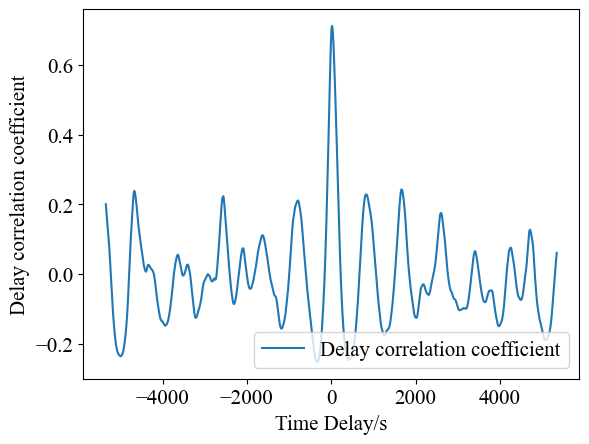

        lag  correlation
0     -5348     0.200261
1     -5347     0.199014
2     -5346     0.197706
3     -5345     0.196331
4     -5344     0.194886
...     ...          ...
10692  5344     0.055731
10693  5345     0.057054
10694  5346     0.058338
10695  5347     0.059585
10696  5348     0.060797

[10697 rows x 2 columns]


In [6]:
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import os


data_path = './data/ft_new2'
scaler = preprocessing.MinMaxScaler(feature_range=(0,200))
#scaler = preprocessing.StandardScaler()
real_data = pd.read_csv('{}/real.csv'.format(data_path))
predict_data = pd.read_csv('{}/predict.csv'.format(data_path))
columns = ["time","CO2","TVOC","CH2O","PM2.5","humidity","temperature","PM10","PM1.0","LUX","MCU","noise"]
real_data.sort_index(axis=0,ascending=True)
predict_data.sort_index(axis=0,ascending=True)
predict_data = np.array(scaler.fit_transform(predict_data.loc[:,["PM2.5"]])).flatten()
real_data = np.array(scaler.fit_transform(real_data.loc[:,["PM2.5"]])).flatten()
print(real_data.shape)


max_lag = int(len(predict_data)/2)
result = lagged_cross_correlation(predict_data, real_data, max_lag)
corr = result.loc[:,'correlation']
print(result[result.lag==0])

print(result.loc[corr.idxmax()])
#plt.title('Virtual sensor PM2.5 prediction')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams.update({"font.size":15})
plt.xlabel('Time Delay/s')
plt.ylabel('Delay correlation coefficient')
plt.plot(result[['lag']],result[['correlation']])
plt.legend(["Delay correlation coefficient"],loc="lower right")
plt.show()
print(result)




对位置2（即贴中间）的做同样操作

(10696,)
lag            68.000000
correlation     0.711379
Name: 5366, dtype: float64


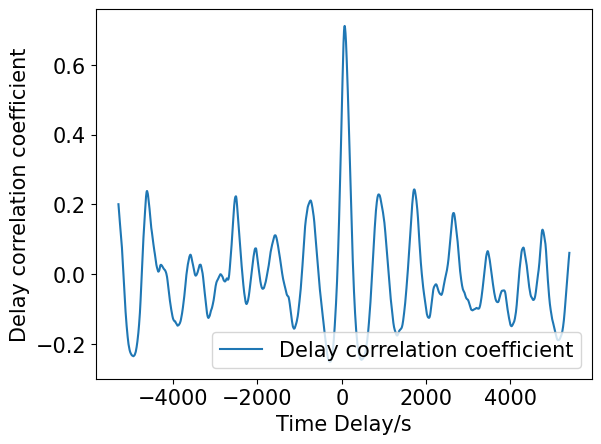

        lag  correlation
0     -5298     0.200261
1     -5297     0.199014
2     -5296     0.197706
3     -5295     0.196331
4     -5294     0.194886
...     ...          ...
10692  5394     0.055731
10693  5395     0.057054
10694  5396     0.058338
10695  5397     0.059585
10696  5398     0.060797

[10697 rows x 2 columns]


In [10]:
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import os


data_path = './data/ft_new2'
scaler = preprocessing.MinMaxScaler(feature_range=(0,200))
#scaler = preprocessing.StandardScaler()
real_data = pd.read_csv('{}/real.csv'.format(data_path))
predict_data = pd.read_csv('{}/predict.csv'.format(data_path))
columns = ["time","CO2","TVOC","CH2O","PM2.5","humidity","temperature","PM10","PM1.0","LUX","MCU","noise"]
real_data.sort_index(axis=0,ascending=True)
predict_data.sort_index(axis=0,ascending=True)
predict_data = np.array(scaler.fit_transform(predict_data.loc[:,["PM2.5"]])).flatten()
real_data = np.array(scaler.fit_transform(real_data.loc[:,["PM2.5"]])).flatten()
print(real_data.shape)


max_lag = int(len(predict_data)/2)
result = lagged_cross_correlation(predict_data, real_data, max_lag)
result[['lag']]=result[['lag']]+50
corr = result.loc[:,'correlation']


print(result.loc[corr.idxmax()])
plt.rcParams.update({"font.size":15})
plt.xlabel('Time Delay/s')
plt.ylabel('Delay correlation coefficient')
plt.plot(result[['lag']],result[['correlation']])
plt.legend(["Delay correlation coefficient"],loc="lower right")
plt.show()
print(result)

In [22]:
import numpy as np
import torch
import torch.nn as nn

class historicalNN(nn.Module):
    def __init__(self,dim,device='cpu'):
        super(historicalNN, self).__init__()
        self.device='cpu'
        self.q_projection = nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=(1,1), bias=True)
        self.k_projection = nn.Conv2d(dim, dim, kernel_size=(1,1), bias=True)
        self.v_projection = nn.Conv2d(dim, dim, kernel_size=(1,1), bias=True)

    def calculate_similarity(self,queries, keys):
    # 计算两个窗口的相似性
    #queries,keys = [b,c,n,t]       
        corr = torch.dot(queries.flatten(),keys.flatten())/queries.flatten().shape[0]
        return corr

    def sliding_window(self, window_size, stride, input_data, history):
        windows = []
        similarities = []
        history_len = history.shape[-1]
    
        for i in range(0, history_len-window_size+1, stride):
            if (i+window_size<history_len):
                window = history[...,i:i+window_size]
                windows.append(window)
            
            if len(windows) > 1:
                Q = self.q_projection(input_data)
                K = self.k_projection(window)  #[b,c,n,t]
                similarity = self.calculate_similarity(Q, K)
                similarities.append(similarity)
        windows = torch.stack(windows)#[Block, b,c,n,t]
        similarities = torch.stack(similarities)  #[Block]
        return windows, similarities

    def get_top_k_similar_windows(self, k, similarities):
        top_k_indices = np.argsort(similarities)[-k:]
        return top_k_indices
    
    def get_historical_data(self):
        path_history = './data/ft_new/history.npy'
        #print(path_assignment)
        self.history = torch.from_numpy(
            np.load(path_history)).float().to(self.device) #[T,n,c]
        
    def forward(self,window_size,x,top_k=50):       
        self.get_historical_data()
        batch = x.shape[0]
        stack_history=[]
        for i in range(batch):
            stack_history.append(self.history)
        histories = torch.stack(stack_history).permute(0,3,2,1) #[b,c,n,T]
        windows,corr=self.sliding_window(window_size=window_size,
                            stride=10,
                            input_data=x,
                            history=histories)

        weights, index = torch.topk(corr,top_k)
        temp_corr = torch.softmax(weights, dim=-1)
        temp_windows = windows[index]
        agg = x.clone()
        for i in range(top_k):
            value = self.v_projection(temp_windows[i])
            agg = agg + value * temp_corr[i]
        print(temp_corr.sum())
        #topk = self.get_top_k_similar_windows(tok_k,similarities=similarities)
        return agg

        
        
data=torch.from_numpy(np.load('./data/ft_new/history.npy')).float()[:100,...]
batch = 64
stack_data=[]
for i in range(batch):
    stack_data.append(data)
data = torch.stack(stack_data).permute(0,3,2,1) #[b,c,n,T]

hs = historicalNN(dim=11)
ind = hs(100,data)
print(ind.shape)


# 测试代码
""" data = np.random.randint(0, 2, size=10000)  # 随机生成10000个二进制数
window_size = 100
stride = 1
k = 50

windows, similarities = sliding_window(window_size, stride, data)
top_k_indices = get_top_k_similar_windows(k, similarities)

print("相似性最高的前{}个窗口的索引：{}".format(k, top_k_indices)) """

tensor(1.0000, grad_fn=<SumBackward0>)
torch.Size([64, 11, 1, 100])


' data = np.random.randint(0, 2, size=10000)  # 随机生成10000个二进制数\nwindow_size = 100\nstride = 1\nk = 50\n\nwindows, similarities = sliding_window(window_size, stride, data)\ntop_k_indices = get_top_k_similar_windows(k, similarities)\n\nprint("相似性最高的前{}个窗口的索引：{}".format(k, top_k_indices)) '

In [20]:
import numpy as np
import torch

a=np.array([1,2,3,4])
b=a
print(id(a),id(b))
a = np.append(a,[1])
print(id(a),id(b))

779726704 779726704
779730352 779726704
